In [125]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns
import math

from sklearn.model_selection import GridSearchCV,ParameterGrid,train_test_split,validation_curve,learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler

from sklearn.metrics import classification_report,f1_score
from sklearn.pipeline import Pipeline

In [126]:
train = pd.read_csv('/Users/nattasorn/Documents/dads_6003/Group_quiz 1/dads-6003-firewall-ml/data_source/train.csv')
test = pd.read_csv('/Users/nattasorn/Documents/dads_6003/Group_quiz 1/dads-6003-firewall-ml/data_source/test.csv')

In [127]:
train.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,51374,445,0,0,drop,70,70,0,1,0,1,0
1,5688,44847,0,0,deny,62,62,0,1,0,1,0
2,53624,445,0,0,drop,66,66,0,1,0,1,0
3,42587,53,63043,53,allow,199,94,105,2,30,1,1
4,56746,445,0,0,drop,70,70,0,1,0,1,0


In [128]:
train_robust = train.copy()
test_robust = test.copy()

X_train_robust = train_robust.loc[:,['Destination Port','NAT Source Port', 'NAT Destination Port', 'Packets', 'Elapsed Time (sec)','Bytes Received']]
y_train_robust = train_robust.loc[:,'Action']
X_test_robust = test_robust.loc[:,['Destination Port','NAT Source Port','NAT Destination Port','Packets', 'Elapsed Time (sec)','Bytes Received']]
y_test_robust = test_robust.loc[:,'Action']

In [129]:
pipe = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier()) # object='multi:softmax',num_class=4,seed=42,eval_metric='merror'
])

hyperparameters = {
    'classifier__n_estimators': [5,6,7,8],  # Number of trees in the forest
    'classifier__max_depth': [3,4,5],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at the leaf nodes

}

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Standardize the features
    ('classifier', RandomForestClassifier())  # Train a Random Forest classifier
])

# Set the hyperparameters for the Random Forest classifier
hyperparameters = {
    'classifier__n_estimators': [5,6,7,8],  # Number of trees in the forest
    'classifier__max_depth': [3,4,5],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at the leaf nodes

}

In [131]:
grid = GridSearchCV(pipe,hyperparameters,cv=5)
grid.fit(X_train_robust, y_train_robust)
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Best parameter (CV score=0.998):
{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 5}
Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=5, min_samples_split=5,
                                        n_estimators=5))])


In [132]:
train_sizes, train_scores, test_scores = learning_curve(pipe, X_train_robust, y_train_robust, cv=5,scoring='f1_weighted')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

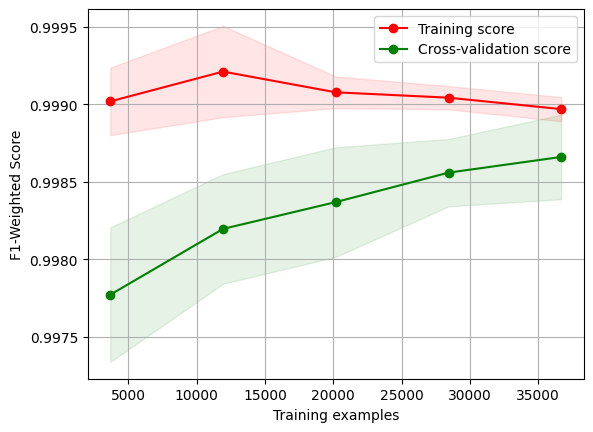

In [133]:
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("F1-Weighted Score")

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")

In [134]:
# Redefine the pipeline using result from gridsearch

Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=5, min_samples_split=5,
                                        n_estimators=7))])

pipe.fit(X_train_robust, y_train_robust,)

print('Training set score: ' + str(pipe.score(X_train_robust,y_train_robust)))
print('Test set score: ' + str(pipe.score(X_test_robust,y_test_robust)))


Training set score: 0.9989754098360656
Test set score: 0.9988809766022381


In [135]:
pipe.fit(X_train_robust, y_train_robust)

train_yhat = pipe.predict(X_train_robust)
train_pipe = pipe.score(X_train_robust,y_train_robust)

test_yhat = pipe.predict(X_test_robust)
test_pipe = pipe.score(X_test_robust,y_test_robust)
print('Train Score\n',classification_report(y_train_robust,train_yhat))
print('Test Score\n',classification_report(y_test_robust, test_yhat))
print(f"AVG F1-Score Train: {train_pipe}\nAVG F1-Score Test: {test_pipe}")

Train Score
               precision    recall  f1-score   support

       allow       1.00      1.00      1.00     26348
        deny       1.00      1.00      1.00     10491
        drop       1.00      1.00      1.00      8995
  reset-both       1.00      0.97      0.99        38

    accuracy                           1.00     45872
   macro avg       1.00      0.99      1.00     45872
weighted avg       1.00      1.00      1.00     45872

Test Score
               precision    recall  f1-score   support

       allow       1.00      1.00      1.00     11292
        deny       1.00      1.00      1.00      4496
        drop       1.00      1.00      1.00      3856
  reset-both       0.87      0.81      0.84        16

    accuracy                           1.00     19660
   macro avg       0.97      0.95      0.96     19660
weighted avg       1.00      1.00      1.00     19660

AVG F1-Score Train: 0.9989754098360656
AVG F1-Score Test: 0.9988809766022381


In [140]:
##waiting for graphviz
# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier

col = ['Destination Port','NAT Source Port', 'NAT Destination Port', 'Packets', 'Elapsed Time (sec)','Bytes Received']

action = pd.array(['allow','drop','deny','reset-both'], dtype='<U10')


estimator = pipeline.named_steps['classifier'].estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = col,
                class_names = action,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')




# # Extract a single decision tree from the Random Forest
# tree = pipeline.named_steps['classifier'].estimators_[0]

# # Export the tree as a Graphviz dot file
# dot_data = export_graphviz(tree, out_file=None, feature_names=iris.feature_names,
#                            class_names=iris.target_names, filled=True, rounded=True,
#                            special_characters=True)

# # Display the graph using Graphviz
# graph = graphviz.Source(dot_data)
# graph.render("iris_tree")
# graph

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

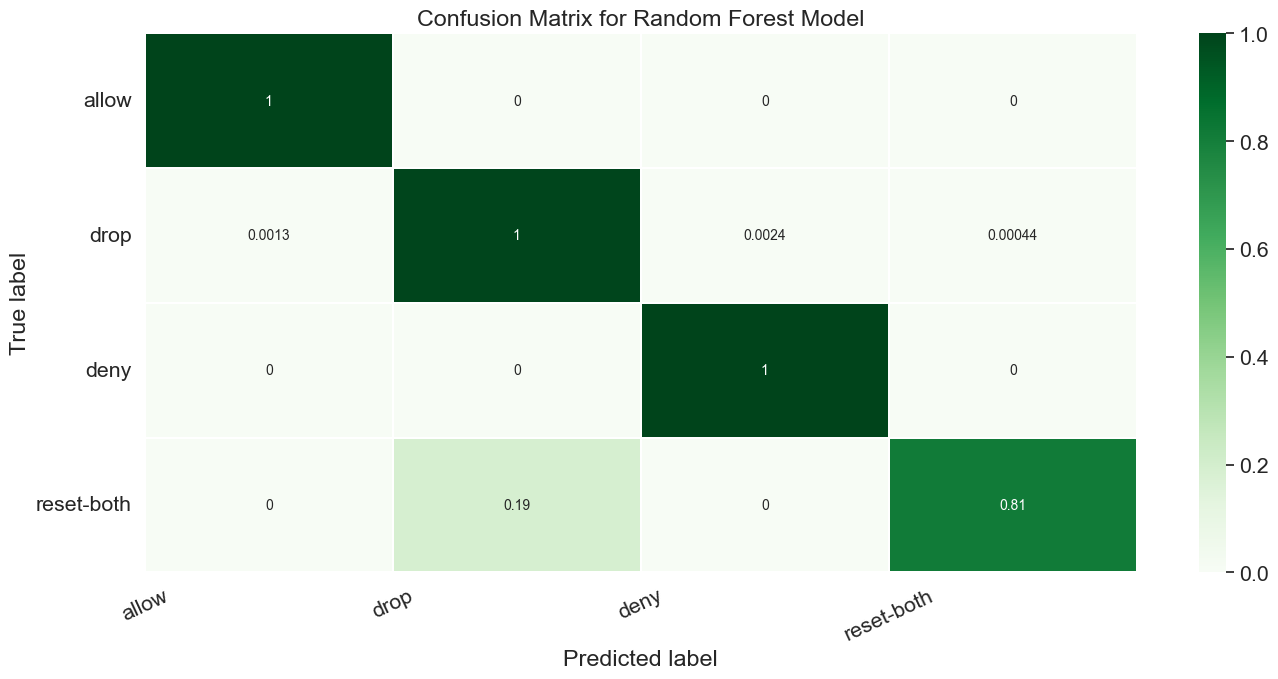

In [141]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test_robust, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['allow','drop','deny','reset-both']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# About 75% of the time, reset-both were mislabeled as drop!